## Projet BigData/BI

Réalisé par : ABDENNROUI Ilyes / LAURENT Emmanuel / LEGRAND Antoine / RONGIER Thomas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline, make_union
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import xgboost as xgb
pd.set_option('display.max_columns', None)

## 1. Introduction 

Dans un contexte ou les talents travaillant dans le domaine de l'immobilier, sont de plus en plus rare, nous avons été mandaté par l'agence immobilière SIAD Immo pour trouver une solution à ce problème de recrutement à l'aide de technique de Machine Learning. Nous avons donc, en accord avec l'entreprise, décidé de mettre en place un outil permettant aux clients de faire estimer leurs biens de façon automatique moyennant une contrepartie financière. Cet outil permettra à l'entreprise de se passer d'une main d'oeuvre qui est de plus en plus difficile à recruter et permettra aux clients de gagner plus de temps. En effet, les estimations se feront de manière instantanée, il n'y aura plus de contrainte de rendez-vous ou de durée d'estimation.  

Pour nous permettre de réaliser notre projet, l'entreprise a mis à notre disposition un jeu de données contenant différentes informations sur 2919 logmements. Ces informations nous renseingent sur la surface du bien, l'état général, la date de construction... En tout et pour tout nous avons à disposition 81 variables.

Notre but, est de mettre en place un modèle de machine learning qui permet d'estimer le prix d'un bien en fonction des caractéristiques de ce dernier.

### Dictionnaire des données

In [2]:
dico = pd.read_excel('C:/Users/Admin/Desktop/Projet_BigData/equipe1-projetbigdatabi2022/dictionnaire_de_données.xlsx')

In [3]:
dico

,Nom champ,Type de données,Longueur du champ,Contrainte,Description
0,Id,Integer,NaN,Primary Key,Identifiant de la ligne
1,MSSubClass,Integer,NaN,Not Null,La classe du bâtiment
2,MSZoning,Varchar,20.0,Not Null,La classe de la zone du bâtiment
3,LotFrontage,Integer,NaN,NaN,Distance en pied reliant la propriété à la rue...
4,LotArea,Integer,NaN,Not Null,Taille de la propriété en pieds carrés
...,...,...,...,...,...
75,MoSold,Integer,NaN,Not Null,Mois vendu (MM)
76,YrSold,Integer,NaN,Not Null,Année de vente (AAAA)
77,SaleType,Varchar,20.0,Not Null,Type de vente
78,SaleCondition,Varchar,20.0,Not Null,Condition de vente


### Importation des données

In [4]:
df_train = pd.read_csv("C:/Users/Admin/Desktop/Projet_BigData/equipe1-projetbigdatabi2022/Data/train.csv")
df_test = pd.read_csv("C:/Users/Admin/Desktop/Projet_BigData/equipe1-projetbigdatabi2022/Data/test.csv")
df_test_sub = pd.read_csv("C:/Users/Admin/Desktop/Projet_BigData/equipe1-projetbigdatabi2022/Data/sample_submission.csv")

In [5]:
#Dans le dataset de test, il manque la variable cible. Cette dernière, se trouve dans un autre dataset
#Il est donc nécessaire de faire une jointure entre ces 2 datasets
#Pour récupérer les informations
df_test = pd.merge(df_test, df_test_sub, how='inner', left_on = 'Id', right_on = 'Id')

In [6]:
#Sur Kaggle, le dataset a déjà été découpé en train et test set. 
#Néanmoins nous ne savons pas de quelle manière ce découpage a été fait.
#Nous allons donc concatener les 2 dataset pour réaliser le découpage nous même..
data = [df_train, df_test]
df = pd.concat(data)

In [7]:
#Apperçu de notre jeu de données après la concatenation 
df.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732.0,Unf,0.0,64.0,796.0,GasA,Ex,Y,SBrkr,796,566,0,1362,1.0,0.0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2.0,480.0,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000.0
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369.0,Unf,0.0,317.0,1686.0,GasA,Ex,Y,SBrkr,1694,0,0,1694,1.0,0.0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2.0,636.0,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000.0
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859.0,BLQ,32.0,216.0,1107.0,GasA,Ex,Y,SBrkr,1107,983,0,2090,1.0,0.0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2.0,484.0,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000.0
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0.0,Unf,0.0,952.0,952.0,GasA,Gd,Y,FuseF,1022,752,0,1774,0.0,0.0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2.0,468.0,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900.0
9,10,190,RL,50.0,7420,Pave,NaN,

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

In [9]:
df.shape

(2919, 81)

## 2. Description des données 

2919 observations et 81 variables caractérisant les biens immobiliers.

In [10]:
#La fonction describe nous permet de décrire de manière très rapide les différents informations 
#sur les variables quantitatives (moyenne, écart-type, val min et max...)
#Nous permettant ainsi de détecter d'enventuels problèmes.
df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,2919.000000,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,2918.000000,2918.000000,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2917.000000,2917.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2760.000000,2918.000000,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,1460.000000,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,49.582248,560.772104,1051.777587,1159.581706,336.483727,4.694416,1500.759849,0.429894,0.061364,1.568003,0.380267,2.860226,1.044536,6.451524,0.597122,1978.113406,1.766621,472.874572,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737,180052.854647
std,842.787043,42.517628,23.344905,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,169.205611,439.543659,440.766258,392.362079,428.701456,46.396825,506.051045,0.524736,0.245687,0.552969,0.502872,0.822693,0.214462,1.569379,0.646129,25.574285,0.761624,215.394815,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964,57381.565721
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,730.500000,20.000000,59.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,0.000000,220.000000,793.000000,876.000000,0.000000,0.000000,1126.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1960.000000,1.000000,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,154795.084126
50%,1460.000000,50.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,0.000000,467.000000,989.500000,1082.000000,0.000000,0.000000,1444.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1979.000000,2.000000,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,176734.841494
75%,2189.500000,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,0.000000,805.500000,1302.000000,1387.500000,704.000000,0.000000,1743.500000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,191895.744157
max,2919.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,2336.000000,6110.000000,5095.000000,2065.000000,1064.000000,5642.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000


## 3. Préparation des données

### Répartition des variables qualitativres

In [11]:
#Fréquence d'apparition des différentes modalités des variables qualitatives
#C'est à dire les variables de type 'object'

#Copie du dataset de base en ne gardant que les variables du type 'object'
df_object = df.select_dtypes(include=['object']).copy()

#Fréquence d'apparition de chaque modalité pour les variables qualitatives
for col in list(df_object.columns):
    print('la variable ' + col +' a '+ str(df_object[col].nunique()) +' modalités :\n ')
    print(df[col].value_counts(normalize=False).map(str) + ' soit: '+round(df[col].value_counts(normalize=True)*100,2).map(str)+'%')
    print('\n')

la variable MSZoning a 5 modalités :
 
RL         2265 soit: 77.7%
RM         460 soit: 15.78%
FV          139 soit: 4.77%
RH           26 soit: 0.89%
C (all)      25 soit: 0.86%
Name: MSZoning, dtype: object


la variable Street a 2 modalités :
 
Pave    2907 soit: 99.59%
Grvl       12 soit: 0.41%
Name: Street, dtype: object


la variable Alley a 2 modalités :
 
Grvl    120 soit: 60.61%
Pave     78 soit: 39.39%
Name: Alley, dtype: object


la variable LotShape a 4 modalités :
 
Reg    1859 soit: 63.69%
IR1     968 soit: 33.16%
IR2        76 soit: 2.6%
IR3       16 soit: 0.55%
Name: LotShape, dtype: object


la variable LandContour a 4 modalités :
 
Lvl    2622 soit: 89.83%
HLS      120 soit: 4.11%
Bnk      117 soit: 4.01%
Low       60 soit: 2.06%
Name: LandContour, dtype: object


la variable Utilities a 2 modalités :
 
AllPub    2916 soit: 99.97%
NoSeWa        1 soit: 0.03%
Name: Utilities, dtype: object


la variable LotConfig a 5 modalités :
 
Inside     2133 soit: 73.07%
Corner   

Les variables comme la variable "Utilities" n'ayant que 2 modalités dont l'une d'entre elles n'est présente qu'une seule occurence ne pourront pas être exploité dans notre modélisation. Les variables que nous allons supprimer sont les suivantes :
- Street
- Utilities
- LandSlope
- Condition2
- BldgType 
- RoofMatl
- Heating 
- Functional
- GarageCond 
- PavedDrive 

In [12]:
#On supprime les variables qui ont beaucoup trop de valeurs manquantes.
df.drop(columns=["Street","Utilities","LandSlope","Condition2","BldgType",
                 "RoofMatl","Heating","Functional","GarageCond","PavedDrive"], inplace=True)

### Renommer les variables : A FAIRE

In [13]:
# On renomme les modalités ayant un nom peu explicite
df.rename(columns={'Id': 'ID',
                   'MSSubClass' : 'classe_bat',
                   'MSZoning' : 'classe_zone_bat',
                   'LotFrontage': 'dist_m_rue',
                   'LotArea' : 'taille_m2_bat',
                   'Street' : 'type_acces_route',
                   'Alley': 'type_acces_ruelle',
                   'LotShape' : 'forme_bat',
                   'LandContour' : 'forme_terrain',
                   'Utilities': 'types_servpublic',
                   'LotConfig' : 'config_lot',
                   'LandSlope' : 'pente',
                   'Neighborhood': 'quartier',
                   'Condition1' : 'proxi_diverses1',
                   'Condition2' : 'proxi_diverses2',
                   'BldgType': 'type_logement',
                   'HouseStyle' : 'style_habitation',
                   'OverallQual' : 'eval_materiaux_finition',
                   'OverallCond': 'eval_etatg',
                   'YearBuilt' : 'annee_construction',
                   'YearRemodAdd' : 'date_renov',
                   'RoofStyle': 'type_toit',
                   'RoofMatl' : 'materiau_toiture',
                   'Exterior1st' : 'revetement_ext',
                   'Exterior2nd': 'revetement_ext2',
                   'MasVnrType' : 'type_placage',
                   'MasVnrArea' : 'zone_placage_m2',
                   'ExterQual': 'quali_materiau_ext',
                   'ExterCond' : 'etat_materiau_ext',
                   'Foundation' : 'type_fondation',
                   'BsmtQual' : 'eval_hauteur_sous-sol',
                   'BsmtCond' : 'eval_etat_sous-sol',
                   'BsmtExposure': 'ref_murs_jardin',
                   'BsmtFinType1': 'eval_surface_sous-sol',
                   'BsmtFinSF1' : 'm2',
                   'BsmtFinSF2' : 'm2_type2',
                   'BsmtFinType2' : 'eval_surface_sous-sol2',
                   'BsmtUnfSF': 'm2_nonfinis-sous-sol',
                   'TotalBsmtSF' : 'm2_sous-sol',
                   'Heating' : 'type_chauffage',
                   'HeatingQC': 'quali_chauffage',
                   'CentralAir' : 'clim_centrale',
                   'Electrical' : 'syst_electrique',
                   '1stFlrSF': 'm2_etage1',
                   '2ndFlrSF' : 'm2_etage2',
                   'LowQualFinSF' : 'm2_bassequali',
                   'GrLivArea' : 'surface_habit',
                   'BsmtFullBath': 'salledebain_sous-sol',
                   'BsmtHalfBath': 'demi_salledebain_sous-sol',
                   'FullBath' : 'salledebain',
                   'HalfBath': 'demi_salledebain',
                   'BedroomAbvGr' : 'nb_chambre',
                   'KitchenAbvGr' : 'nb_cuisine',
                   'KitchenQual': 'quali_cuisine',
                   'TotRmsAbvGrd' : 'nb_piece_hors_sous-sol',
                   'Functional' : 'fontionnement_maison',
                   'Fireplaces' : 'nb_foyers',
                   'FireplaceQu': 'qualite_foyers',
                   'GarageType' : 'emplacement_garage',
                   'GarageYrBlt' : 'annee_contruct_garage',
                   'GarageFinish': 'finition_garage',
                   'GarageCars' : 'nb_voiture_garage',
                   'GarageArea' : 'garage_m2',
                   'GarageQual': 'quali_garage',
                   'GarageCond' : 'etat_garage',
                   'PavedDrive' : 'allee_pavee',
                   'WoodDeckSF': 'surface_terrasse_m2',
                   'OpenPorchSF' : 'surface_porche_o_m2',
                   'EnclosedPorch' : 'surface_porche_f_m2',
                   '3SsnPorch': 'surface_porche3s_m2',
                   'ScreenPorch' : 'surface_veranda',
                   'PoolArea' : 'surface_piscine_m2',
                   'PoolQC': 'quali_piscine',
                   'Fence' : 'quali_clotures',
                   'MiscFeature' : 'carac_diverse',
                   'MiscVal' : 'valeur_elem_divers',
                   'MoSold' : 'mois_vendu',
                   'YrSold': 'annee_vente',
                   'SaleType' : 'type_vente',
                   'SaleCondition' : 'condition_vente',
                   'SalePrice' : 'prix_vente'
                   },
                   inplace=True)

### Les valeurs manquantes : A FAIRE

In [14]:
# Compter le nombre d'observations manquantes pour chaque colonne
missing_values = df.isna().sum()

# Afficher le nombre d'observations manquantes pour chaque colonne
print(missing_values)

missing_values_percent = round((df.isna().sum() / len(df)) * 100,2)
print(missing_values_percent.to_string())

ID                   0
classe_bat           0
classe_zone_bat      4
dist_m_rue         486
taille_m2_bat        0
                  ... 
mois_vendu           0
annee_vente          0
type_vente           1
condition_vente      0
prix_vente           0
Length: 71, dtype: int64
ID                            0.00
classe_bat                    0.00
classe_zone_bat               0.14
dist_m_rue                   16.65
taille_m2_bat                 0.00
type_acces_ruelle            93.22
forme_bat                     0.00
forme_terrain                 0.00
config_lot                    0.00
quartier                      0.00
proxi_diverses1               0.00
style_habitation              0.00
eval_materiaux_finition       0.00
eval_etatg                    0.00
annee_construction            0.00
date_renov                    0.00
type_toit                     0.00
revetement_ext                0.03
revetement_ext2               0.03
type_placage                  0.82
zone_placage_m2       

### Les valeurs aberrantes : A FAIRE

### Pour les variables quantitatives

In [15]:
#On récupère les variables quantitives 
df_int = df.select_dtypes(include=['int64','float64']).copy()

# Detection des valeurs aberrantes avec la méthode du Z score
for col in list(df_int.columns):
    mean = np.mean(df_int[col])
    std = np.std(df_int[col])

    threshold = 3
    outlier = []
    for i in df[col]:
        z = (i-mean)/std
        if z > threshold:
            outlier.append(i)
    print('les outliers pour la varible' + col + 'suivants : ', outlier)
    print('\n')

les outliers pour la varibleIDsuivants :  []


les outliers pour la varibleclasse_batsuivants :  [190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190]


les outliers pour la varibledist_m_ruesuivants :  [141.0, 174.0, 174.0, 140.0, 150.0, 144.0, 149.0, 313.0, 168.0, 182.0, 160.0, 152.0, 313.0, 153.0, 150.0, 160.0, 195.0, 155.0, 149.0, 200.0, 140.0, 160.0]


les outliers pour la varibletaille_m2_batsuivants :  [50271, 159000, 39104, 215245, 164660, 53107, 34650, 70761, 53227, 40094, 46589, 115149, 53504, 45600, 35760, 35133, 36500, 63887, 57200, 47280, 47007, 56600, 51974, 41600, 39290, 43500, 33983, 39384, 50102]


les outliers pour la varibleeval_materiaux_finitionsuivants :  []


les outliers pour la varibleeval_etatgsuivants :  [9, 9, 

Nous avons ici, pour chacune de nos variables quantitatives les valeurs qui sont aberrantes. Pour traiter ces valeurs, nous avons plusieurs solutions :

    - supprimer les valeurs aberrantes
    - créer des classes pour atténuer l'impact des valeurs aberrantes
    - imputer les valeurs.
    
N'ayant pas beaucoup d'obeservations, nous avons choisis de créer des classes. Ainsi, nous évitons de perdre de l'information.

### Suppression de certaines variables selon les valeurs manquantes

Nous allons procéder à une première suppression des variables qui ne sont pas exploitables. Nous allons supprimer les variables ayant trop de valeurs manquantes, ou ayant une seule modalité ou une modalité qui revient presque à chaque fois comme par exemple avec la variable "Utilities" qui a une modlité présente 99.97% et une autre présente 0.03%.

In [16]:
#On supprime les variables qui ont beaucoup trop de valeurs manquantes.
df.drop(columns=["dist_m_rue","type_acces_ruelle","qualite_foyers","quali_piscine","quali_clotures","carac_diverse"], inplace=True)

In [17]:
#On copie le dataframe
df2 = df

### On rempalce les NA de certaines variables

In [18]:
#On Remplace les observations ayant des valeurs manquantes pour les variables ayant un rapport avec le sous-sol
#En effet, on suppose que s'il y a une valeur manquantes, il n'y a pas de sous-sol
df2['eval_hauteur_sous-sol'].fillna("pas de sous-sol", inplace=True)
df2['eval_etat_sous-sol'].fillna("pas de sous-sol", inplace=True)
df2['ref_murs_jardin'].fillna("pas de sous-sol", inplace=True)
df2['eval_surface_sous-sol'].fillna("pas de sous-sol", inplace=True)
df2['eval_surface_sous-sol2'].fillna("pas de sous-sol", inplace=True)
df2['m2'].fillna("pas de sous-sol", inplace=True)
df2['m2_nonfinis-sous-sol'].fillna("pas de sous-sol", inplace=True)
df2['m2_sous-sol'].fillna("pas de sous-sol", inplace=True)
df2['salledebain_sous-sol'].fillna("pas de sous-sol", inplace=True)
df2['demi_salledebain_sous-sol'].fillna("pas de sous-sol", inplace=True)


In [19]:
#On Remplace les observations ayant des valeurs manquantes pour les variables ayant un rapport avec le de garage
#En effet, on suppose que s'il y a une valeur manquantes, il n'y a pas de garage
df2['emplacement_garage'].fillna("pas de garage", inplace=True)
df2['annee_contruct_garage'].fillna("pas de garage", inplace=True)
df2['finition_garage'].fillna("pas de garage", inplace=True)
df2['quali_garage'].fillna("pas de garage", inplace=True)
df2['nb_voiture_garage'].fillna("pas de garage", inplace=True)
df2['garage_m2'].fillna("pas de garage", inplace=True)

### On suppripmer les observartions des variables ayant peu de valeurs manquantes 

In [20]:
df

,ID,classe_bat,classe_zone_bat,taille_m2_bat,forme_bat,forme_terrain,config_lot,quartier,proxi_diverses1,style_habitation,eval_materiaux_finition,eval_etatg,annee_construction,date_renov,type_toit,revetement_ext,revetement_ext2,type_placage,zone_placage_m2,quali_materiau_ext,etat_materiau_ext,type_fondation,eval_hauteur_sous-sol,eval_etat_sous-sol,ref_murs_jardin,eval_surface_sous-sol,m2,eval_surface_sous-sol2,m2_type2,m2_nonfinis-sous-sol,m2_sous-sol,quali_chauffage,clim_centrale,syst_electrique,m2_etage1,m2_etage2,m2_bassequali,surface_habit_sous-sol,salledebain_sous-sol,demi_salledebain_sous-sol,salledebain,demi_salledebain,nb_chambre,nb_cuisine,quali_cuisine,nb_piece_sous-sol,nb_foyers,emplacement_garage,annee_contruct_garage,finition_garage,nb_voiture_garage,garage_m2,quali_garage,surface_terrasse_m2,surface_porche_o_m2,surface_porche_f_m2,surface_porche3s_m2,surface_veranda,surface_piscine_m2,valeur_elem_divers,mois_vendu,annee_vente,type_vente,condition_vente,prix_vente
0,1,60,RL,8450,Reg,Lvl,Inside,CollgCr,Norm,2Story,7,5,2003,2003,Gable,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,0,Attchd,2003.0,RFn,2.0,548.0,TA,0,61,0,0,0,0,0,2,2008,WD,Normal,208500.000000
1,2,20,RL,9600,Reg,Lvl,FR2,Veenker,Feedr,1Story,6,8,1976,1976,Gable,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,1,Attchd,1976.0,RFn,2.0,460.0,TA,298,0,0,0,0,0,0,5,2007,WD,Normal,181500.000000
2,3,60,RL,11250,IR1,Lvl,Inside,CollgCr,Norm,2Story,7,5,2001,2002,Gable,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,1,Attchd,2001.0,RFn,2.0,608.0,TA,0,42,0,0,0,0,0,9,2008,WD,Normal,223500.000000
3,4,70,RL,9550,IR1,Lvl,Corner,Crawfor,Norm,2Story,7,5,1915,1970,Gable,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,1,Detchd,1998.0,Unf,3.0,642.0,TA,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000.000000
4,5,60,RL,14260,IR1,Lvl,FR2,NoRidge,Norm,2Story,8,5,2000,2000,Gable,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,1,Attchd,2000.0,RFn,3.0,836.0,TA,192,84,0,0,0,0,0,12,2008,WD,Normal,250000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,1936,Reg,Lvl,Inside,MeadowV,Norm,2Story,4,7,1970,1970,Gable,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,0,pas de garage,pas de garage,pas de garage,0.0,0.0,pas de garage,0,0,0,0,0,0,0,6,2006,WD,Normal,167081.220949
1455,2916,160,RM,1894,Reg,Lvl,Inside,MeadowV,Norm,2Story,4,5,1970,1970,Gable,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,0,CarPort,1970.0,Unf,1.0,286.0,TA,0,24,0,0,0,0,0,4,2006,WD,Abnorml,164788.778231
1456,2917,20,RL,20000,Reg,Lvl,Inside,Mitchel,Norm,1Story,5,7,1960,1996,Gable,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,1,Detchd,1960.0,Unf,2.0,576.0,TA,474,0,0,0,0,0,0,9,2006,WD,Abnorml,219222.423400
1457,2918,85,RL,10441,Reg,Lvl,Inside,Mitchel,Norm,SFoyer,5,5,1992,1992,Gable,HdBoard,Wd Shng,None,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,337.0,Unf,0.0,575.0,912.0,TA,Y,SBrkr,970,0,0,970,0.0,1.0,1,0,3,1,TA,6,0,pas de garage,pas de garage,pas de garage,0.0,0.0,pas de garage,80,32,0,0,0,0,700,7,2006,WD,Normal,184924.279659


In [21]:
df2

,ID,classe_bat,classe_zone_bat,taille_m2_bat,forme_bat,forme_terrain,config_lot,quartier,proxi_diverses1,style_habitation,eval_materiaux_finition,eval_etatg,annee_construction,date_renov,type_toit,revetement_ext,revetement_ext2,type_placage,zone_placage_m2,quali_materiau_ext,etat_materiau_ext,type_fondation,eval_hauteur_sous-sol,eval_etat_sous-sol,ref_murs_jardin,eval_surface_sous-sol,m2,eval_surface_sous-sol2,m2_type2,m2_nonfinis-sous-sol,m2_sous-sol,quali_chauffage,clim_centrale,syst_electrique,m2_etage1,m2_etage2,m2_bassequali,surface_habit_sous-sol,salledebain_sous-sol,demi_salledebain_sous-sol,salledebain,demi_salledebain,nb_chambre,nb_cuisine,quali_cuisine,nb_piece_sous-sol,nb_foyers,emplacement_garage,annee_contruct_garage,finition_garage,nb_voiture_garage,garage_m2,quali_garage,surface_terrasse_m2,surface_porche_o_m2,surface_porche_f_m2,surface_porche3s_m2,surface_veranda,surface_piscine_m2,valeur_elem_divers,mois_vendu,annee_vente,type_vente,condition_vente,prix_vente
0,1,60,RL,8450,Reg,Lvl,Inside,CollgCr,Norm,2Story,7,5,2003,2003,Gable,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,0,Attchd,2003.0,RFn,2.0,548.0,TA,0,61,0,0,0,0,0,2,2008,WD,Normal,208500.000000
1,2,20,RL,9600,Reg,Lvl,FR2,Veenker,Feedr,1Story,6,8,1976,1976,Gable,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,1,Attchd,1976.0,RFn,2.0,460.0,TA,298,0,0,0,0,0,0,5,2007,WD,Normal,181500.000000
2,3,60,RL,11250,IR1,Lvl,Inside,CollgCr,Norm,2Story,7,5,2001,2002,Gable,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,1,Attchd,2001.0,RFn,2.0,608.0,TA,0,42,0,0,0,0,0,9,2008,WD,Normal,223500.000000
3,4,70,RL,9550,IR1,Lvl,Corner,Crawfor,Norm,2Story,7,5,1915,1970,Gable,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,1,Detchd,1998.0,Unf,3.0,642.0,TA,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000.000000
4,5,60,RL,14260,IR1,Lvl,FR2,NoRidge,Norm,2Story,8,5,2000,2000,Gable,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,1,Attchd,2000.0,RFn,3.0,836.0,TA,192,84,0,0,0,0,0,12,2008,WD,Normal,250000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,1936,Reg,Lvl,Inside,MeadowV,Norm,2Story,4,7,1970,1970,Gable,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,0,pas de garage,pas de garage,pas de garage,0.0,0.0,pas de garage,0,0,0,0,0,0,0,6,2006,WD,Normal,167081.220949
1455,2916,160,RM,1894,Reg,Lvl,Inside,MeadowV,Norm,2Story,4,5,1970,1970,Gable,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,0,CarPort,1970.0,Unf,1.0,286.0,TA,0,24,0,0,0,0,0,4,2006,WD,Abnorml,164788.778231
1456,2917,20,RL,20000,Reg,Lvl,Inside,Mitchel,Norm,1Story,5,7,1960,1996,Gable,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,1,Detchd,1960.0,Unf,2.0,576.0,TA,474,0,0,0,0,0,0,9,2006,WD,Abnorml,219222.423400
1457,2918,85,RL,10441,Reg,Lvl,Inside,Mitchel,Norm,SFoyer,5,5,1992,1992,Gable,HdBoard,Wd Shng,None,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,337.0,Unf,0.0,575.0,912.0,TA,Y,SBrkr,970,0,0,970,0.0,1.0,1,0,3,1,TA,6,0,pas de garage,pas de garage,pas de garage,0.0,0.0,pas de garage,80,32,0,0,0,0,700,7,2006,WD,Normal,184924.279659


In [22]:
df2.dropna(subset=['classe_zone_bat','type_placage','zone_placage_m2','syst_electrique','quali_cuisine','type_vente'], inplace=True)

In [23]:
df2.shape

(2888, 65)

On passe de 2919 observations à 2657

## Corrélation

<AxesSubplot: >

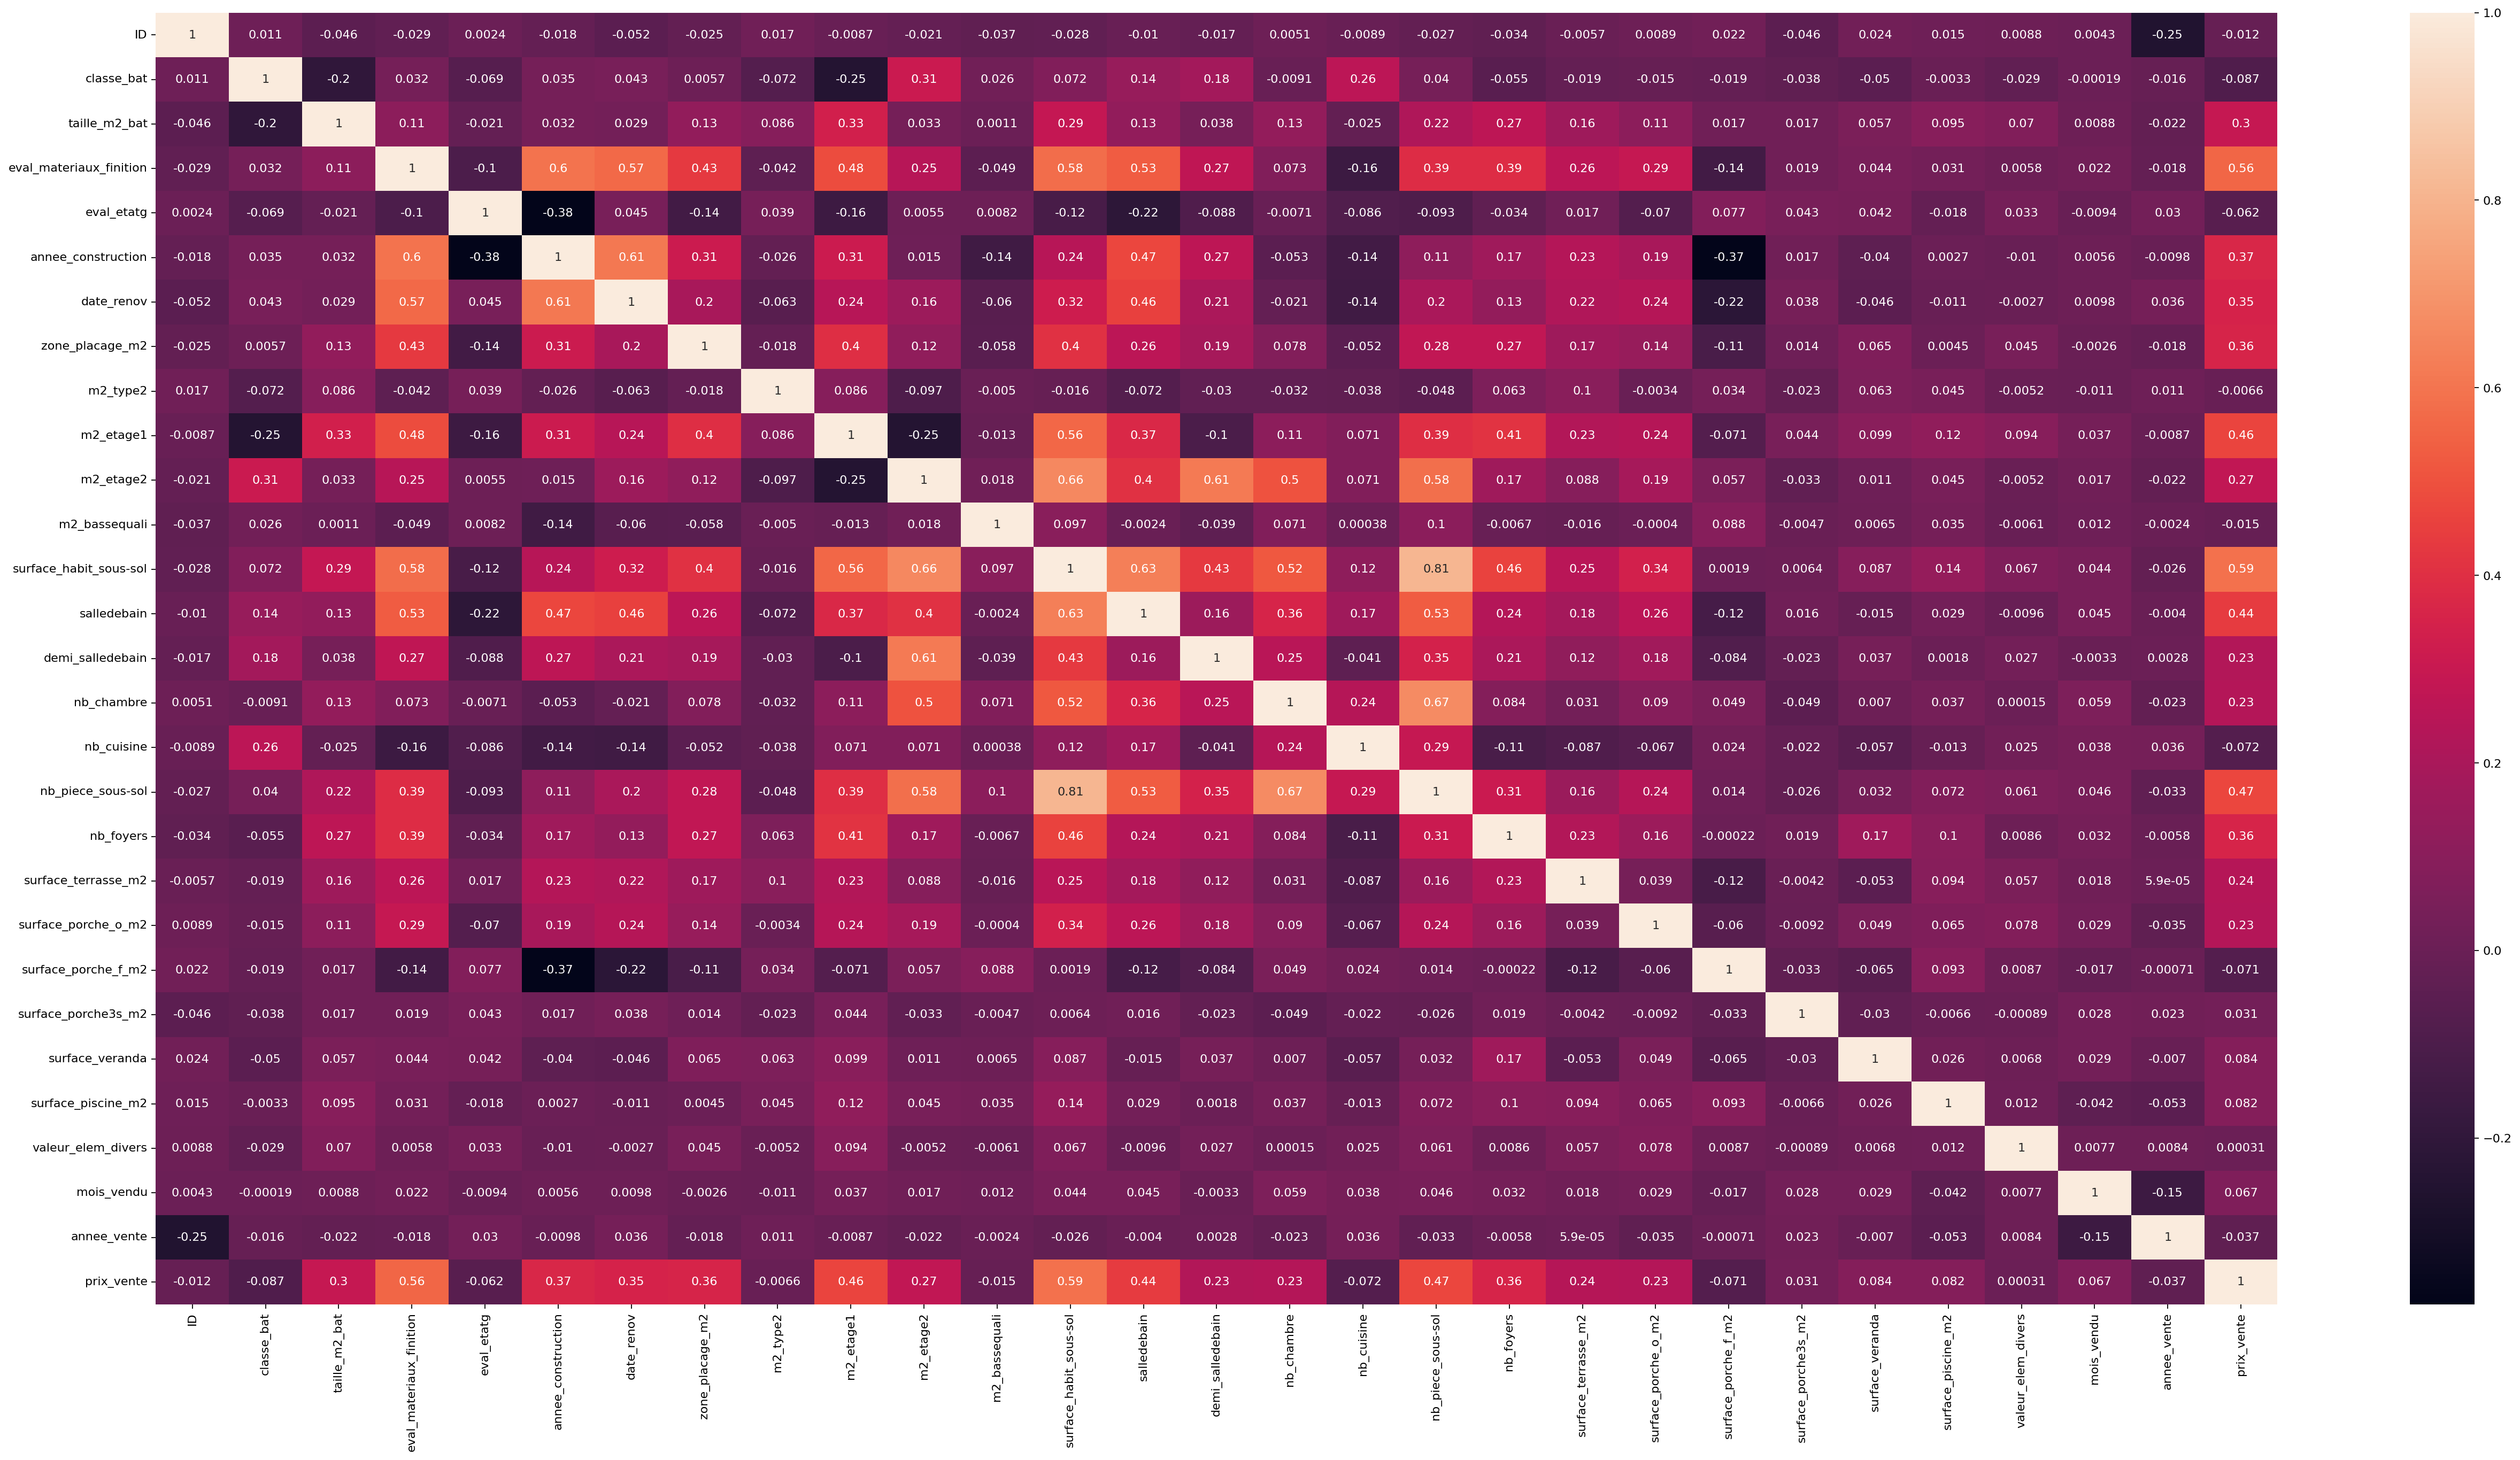

In [26]:
corr_matrix = df2.corr()


# afficher la matrice de corrélation
plt.rcParams['figure.dpi'] = 160
plt.rcParams['figure.figsize'] = (40, 20)
sns.heatmap(corr_matrix, annot=True)

### Regroupement des modalitées

In [25]:
# Regroupement de la variable âge
# On s'aide des Quartile et de la médiane pour les déterminer 
df_3.loc[df['age'] <= 28,'age'] = '17-28 ans'
df_3.loc[(df['age'] >= 29) & (df['age'] <= 37),'age'] = '29-37 ans'
df_3.loc[(df['age'] >= 38) & (df['age'] <= 48),'age'] = '38-48 ans'
df_3.loc[(df['age'] >= 49) & (df['age'] <= 60),'age'] = '49-60 ans'
df_3.loc[df['age'] >= 61,'age'] = '61 ans et +'

NameError: name 'df_3' is not defined

## 4. Modélisation 

### Échantillonnage 

In [ ]:
#On ne va pas travailler sur la totalité de nos observations, il est important de réaliser un échantillonnage 
#Train set, Test set
y = df['prix_vente'] #On défini la variable a expliquer
y=y.astype('int')
X = df.drop(columns = ["prix_vente"], inplace=True) # On défini nos features

### Dummies

In [ ]:
X = pd.get_dummies(X)
X

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.80, test_size=0.20, random_state=0, stratify=y) 
# On réalise l'échantillonage en splitant le datasets a 80% pour le train set et 20% pour le test set
# On initialise un random_state égal à 0 pour obtenir toujours le même tirage aléatoire
# On initialise le paramètre de stratification afin de conserver la répartition par strate